In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# =============================================================================
# 2-Satellite Constellation Optimization with Multi-Constraints
# =============================================================================


In [2]:
# Define constraints for optimisation

def coverage_matrix(theta):
    """Coverage quality matrix based on satellite separation angle theta."""
    overlap = np.cos(theta/2)  # More overlap when satellites are closer
    return np.array([[1.0, overlap],
                     [overlap, 1.0]])

def redundancy_matrix(theta):
    """Redundancy matrix - we WANT some overlap for failure tolerance."""
    overlap = np.cos(theta/2)
    redundancy = overlap**2  # Quadratic penalty for no redundancy
    return np.array([[redundancy, overlap],
                     [overlap, redundancy]])

def communication_matrix(theta):
    """Inter-satellite communication quality matrix."""
    # Communication quality decreases with distance
    # But too close satellites interfere with each other
    distance = abs(theta)
    if distance > np.pi:
        distance = 2*np.pi - distance  # Wrap around for shorter arc
    
    # Optimal communication at medium distances
    comm_quality = np.exp(-(distance - np.pi/2)**2)  # Peak at 90° separation
    return np.array([[0, comm_quality],
                     [comm_quality, 0]])

def combined_matrix(theta, w_coverage=0.6, w_redundancy=0.3, w_comm=0.1):
    """Weighted combination of all constraint matrices."""
    C_cov = coverage_matrix(theta)
    C_red = redundancy_matrix(theta)
    C_comm = communication_matrix(theta)
    
    return w_coverage * C_cov + w_redundancy * C_red + w_comm * C_comm


In [3]:

def objective_function(theta, weights=(0.6, 0.3, 0.1)):
    """Objective: maximize minimum eigenvalue of combined system."""
    C = combined_matrix(theta, *weights)
    eigenvals = np.linalg.eigvals(C)
    return -np.min(eigenvals)  # Negative because we want to maximize

def analyze_constellation():
    """Analyze how constellation performance varies with satellite separation."""
    
    # Grid search across all possible separations
    thetas = np.linspace(0, 2*np.pi, 1000)
    objectives = []
    min_eigenvals = []
    max_eigenvals = []
    
    for theta in thetas:
        C = combined_matrix(theta)
        eigenvals = np.linalg.eigvals(C)
        eigenvals = np.sort(eigenvals)
        
        objectives.append(-objective_function(theta))
        min_eigenvals.append(eigenvals[0])
        max_eigenvals.append(eigenvals[1])
    
    # Find optimal configuration
    optimal_idx = np.argmax(objectives)
    optimal_theta = thetas[optimal_idx]
    optimal_performance = objectives[optimal_idx]
    
    # Create comprehensive visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Overall objective function
    ax1.plot(thetas * 180/np.pi, objectives, 'b-', linewidth=2, label='Combined Objective')
    ax1.axvline(optimal_theta * 180/np.pi, color='r', linestyle='--', 
                label=f'Optimal: {optimal_theta*180/np.pi:.1f}°')
    ax1.set_xlabel('Satellite Separation (degrees)')
    ax1.set_ylabel('System Performance')
    ax1.set_title('Multi-Constraint Optimization Result')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Eigenvalue spectrum
    ax2.plot(thetas * 180/np.pi, min_eigenvals, 'r-', linewidth=2, label='Min Eigenvalue')
    ax2.plot(thetas * 180/np.pi, max_eigenvals, 'g-', linewidth=2, label='Max Eigenvalue')
    ax2.axvline(optimal_theta * 180/np.pi, color='black', linestyle='--', alpha=0.7)
    ax2.set_xlabel('Satellite Separation (degrees)')
    ax2.set_ylabel('Eigenvalue')
    ax2.set_title('Eigenvalue Spectrum Analysis')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Individual constraint contributions
    coverage_objs = [-np.min(np.linalg.eigvals(coverage_matrix(theta))) for theta in thetas]
    redundancy_objs = [-np.min(np.linalg.eigvals(redundancy_matrix(theta))) for theta in thetas]
    comm_objs = [-np.min(np.linalg.eigvals(communication_matrix(theta))) for theta in thetas]
    
    ax3.plot(thetas * 180/np.pi, coverage_objs, 'b-', label='Coverage', linewidth=2)
    ax3.plot(thetas * 180/np.pi, redundancy_objs, 'orange', label='Redundancy', linewidth=2)
    ax3.plot(thetas * 180/np.pi, comm_objs, 'green', label='Communication', linewidth=2)
    ax3.axvline(optimal_theta * 180/np.pi, color='r', linestyle='--', alpha=0.7)
    ax3.set_xlabel('Satellite Separation (degrees)')
    ax3.set_ylabel('Individual Performance')
    ax3.set_title('Individual Constraint Analysis')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Configuration visualization
    ax4.set_xlim(-1.5, 1.5)
    ax4.set_ylim(-1.5, 1.5)
    
    # Draw Earth
    earth = plt.Circle((0, 0), 1, fill=False, color='blue', linewidth=3)
    ax4.add_patch(earth)
    
    # Draw optimal satellite positions
    sat1_x, sat1_y = 1.3 * np.cos(0), 1.3 * np.sin(0)
    sat2_x, sat2_y = 1.3 * np.cos(optimal_theta), 1.3 * np.sin(optimal_theta)
    
    ax4.plot(sat1_x, sat1_y, 'ro', markersize=10, label='Satellite 1')
    ax4.plot(sat2_x, sat2_y, 'go', markersize=10, label='Satellite 2')
    
    # Draw coverage areas (simplified)
    coverage1 = plt.Circle((sat1_x, sat1_y), 0.5, alpha=0.3, color='red')
    coverage2 = plt.Circle((sat2_x, sat2_y), 0.5, alpha=0.3, color='green')
    ax4.add_patch(coverage1)
    ax4.add_patch(coverage2)
    
    # Draw communication link
    ax4.plot([sat1_x, sat2_x], [sat1_y, sat2_y], 'k--', alpha=0.7, linewidth=2)
    
    ax4.set_aspect('equal')
    ax4.set_title(f'Optimal Configuration: {optimal_theta*180/np.pi:.1f}° Separation')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print optimization results
    print("🛰️ CONSTELLATION OPTIMIZATION RESULTS")
    print("=" * 50)
    print(f"Optimal satellite separation: {optimal_theta*180/np.pi:.1f}°")
    print(f"System performance score: {optimal_performance:.3f}")
    print(f"Performance at 0° (same position): {-objective_function(0):.3f}")
    print(f"Performance at 180° (opposite): {-objective_function(np.pi):.3f}")
    print(f"Performance at 90° (perpendicular): {-objective_function(np.pi/2):.3f}")
    
    # Analyze optimal configuration
    C_optimal = combined_matrix(optimal_theta)
    eigenvals_optimal = np.linalg.eigvals(C_optimal)
    print(f"\nOptimal configuration eigenvalues: {eigenvals_optimal}")
    print(f"Minimum eigenvalue (bottleneck): {np.min(eigenvals_optimal):.3f}")
    
    return optimal_theta, optimal_performance


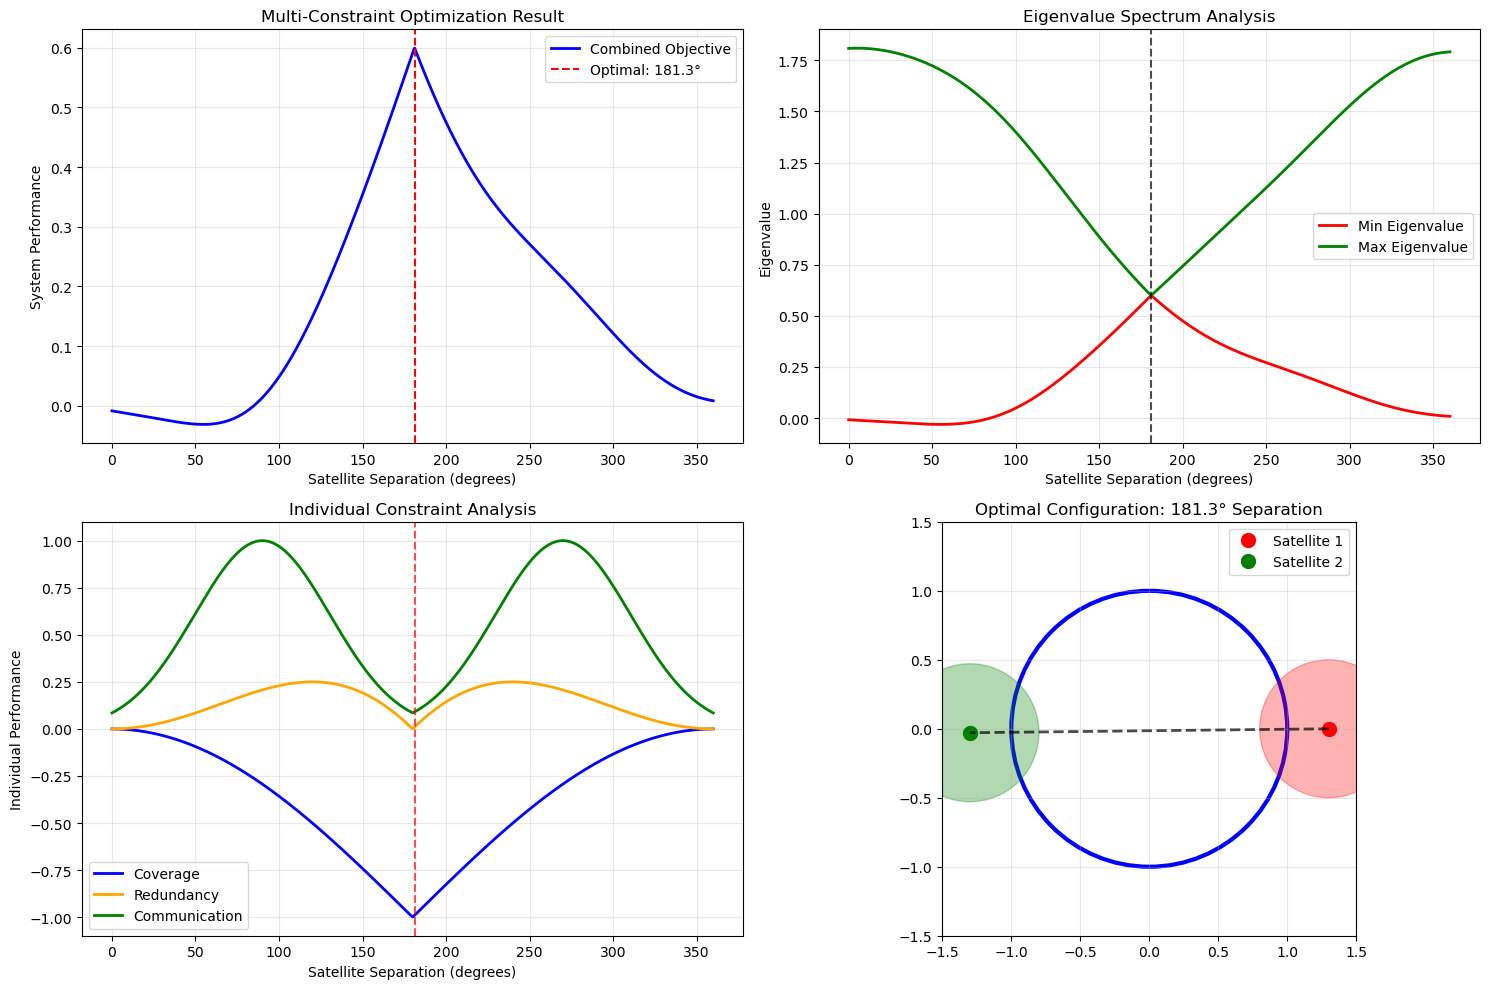

🛰️ CONSTELLATION OPTIMIZATION RESULTS
Optimal satellite separation: 181.3°
System performance score: 0.599
Performance at 0° (same position): -0.008
Performance at 180° (opposite): 0.592
Performance at 90° (perpendicular): 0.014

Optimal configuration eigenvalues: [0.60085873 0.59921395]
Minimum eigenvalue (bottleneck): 0.599


(np.float64(3.163605815326658), np.float64(0.5992139494605997))

In [4]:
analyze_constellation()

In [18]:
# Define coverage matrices for n satellites

# define the function - what interface do we need?

#  we need the number of satellites and the angle of satellite separation theta. But now we can have more than, so one angle can no longer fully descr
# describe the satellite separation. We need positioins for each satellite, in lat and long. We need a function to maximise for coverage. we started with 
# np.cos(theta/2) as a simplified optimisiatioin function. How does this translate into lat, long for more than 2 satellites?
# interface is coverage_matracies(n, positions) what kind of object do we need to store n poisitions? np.array([[lat1,lon1], [lat2,lon2], [...]])?
# but if we have the array of n positions, we don't need in0put n, becuase it can be derived from the array. so our interface is:
# for coverage_matrix_n to work we need to:
# 1. convert positions to cartesian coorindates
# 2. calculate the spherical distance
# 3. calculate the coverage overlap to optimise

def great_circle_distance(lat1, lon1, lat2, lon2):
    """calculates great circle (angluar) distancce between two geographical coorindates"""
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])

    x1 = np.cos(lat1_rad) * np.cos(lon1_rad)
    y1 = np.cos(lat1_rad) * np.sin(lon1_rad) 
    z1 = np.sin(lat1_rad)

    x2 = np.cos(lat2_rad) * np.cos(lon2_rad)
    y2 = np.cos(lat2_rad) * np.sin(lon2_rad) 
    z2 = np.sin(lat2_rad)

    # dot product of the two vectors is the cos of the angle between the two coordinates
    dot_product = x1*x2 + y1*y2 + z1*z2
    angular_distance = np.arccos(max(-1, min(1, dot_product))) # force beetween 0 and 1 for numeric stability

    return angular_distance

def spherical_coverage_overlap(lat1, lon1, lat2, lon2):
    """calulate the overlap to optimise coverage"""

    angular_distance = great_circle_distance(lat1, lon1, lat2, lon2)

    overlap = np.cos(angular_distance/2)

    return max(0,overlap)



def coverage_matrix_n(satellite_positions):
    """derive the coverage matrix for n satellites"""

    number_satelites = len(satellite_positions)

    C = np.zeros((number_satelites, number_satelites))

    for i in range(number_satelites):
        for j in range(number_satelites):

            if i == j: 
                C[i,j] = 1
            else: 
                C[i,j] = spherical_coverage_overlap(satellite_positions[i][0], satellite_positions[i][1], 
                                                    satellite_positions[j][0], satellite_positions[j][1])
                

    return C




In [19]:
# test for 3 satellites

satellite_positions = np.array([[12,14], [45, 54], [78, 98]])

C = coverage_matrix_n(satellite_positions)

print(f" empty coverage matrix, {np.zeros((len(satellite_positions), len(satellite_positions)))}")
print(f" our first 3d coverage matrix {C}")

 empty coverage matrix, [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
 our first 3d coverage matrix [[1.         0.91565662 0.78250434]
 [0.91565662 1.         0.94800029]
 [0.78250434 0.94800029 1.        ]]
